In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels

In [3]:
from rkhs import compute_shifted_coverage, compute_adaptive_threshold
from Synthetic_data_generation import generate_cqr_data
from rkhs import runCV

100%|███████████████████████████████████████████| 40/40 [00:36<00:00,  1.09it/s]


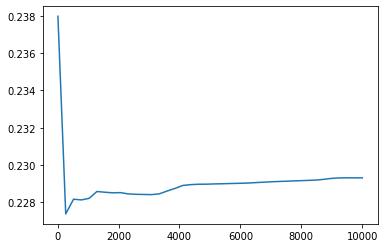

100%|███████████████████████████████████████████| 40/40 [12:13<00:00, 18.34s/it]


ValueError: x and y must have same first dimension, but have shapes (4,) and (6,)

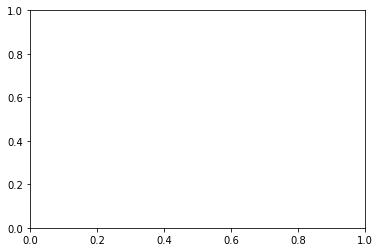

In [25]:
def run_one_cv_trial(alpha, gamma, k = 5, n_train=[1000],
                     num_radii=30,min_radius=1, max_radius=100):    
    
    x_train_final, y_train_final, x_calib, y_calib, _, _ = generate_cqr_data(n_train = 2*max(n_train),
                                                                             n_test = 2)
    reg = LinearRegression().fit(x_train_final, y_train_final)
    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    
    lossList = []
    radiiList = []
    bestRadius = []
    for i in range(len(n_train)):
        allLosses, radii = runCV(x_calib[0:n_train[i],:],scores_calib[0:n_train[i]],
                                   "rbf",gamma,alpha,k,num_radii=num_radii,
                                   min_radius = min_radius,max_radius=max_radius)
        lossList.append(allLosses)
        radiiList.append(radii)
        bestRadius.append(radii[np.argmin(allLosses)])
    return lossList, radiiList, bestRadius

alpha = 0.9
gamma = 2
allLosses, radii, bestRadius = run_one_cv_trial(alpha, gamma, k = 5,
                                                n_train=[500],num_radii=40,
                                                min_radius=10,max_radius=10000)
plt.plot(radii[0],allLosses[0])
plt.show()

minLamb = []
lossList = []
lossList, radiiList, minRadius = run_one_cv_trial(alpha, gamma, k = 5,
                                          n_train=[250,500,750,1000,1500,2000],
                                          num_radii=40,min_radius=10,max_radius=10000)

plt.plot([250,500,750,1000,1500,2000],minRadius)
plt.show()


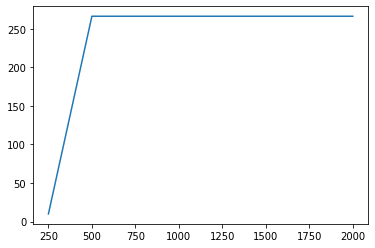

[   10.           266.15384615   522.30769231   778.46153846
  1034.61538462  1290.76923077  1546.92307692  1803.07692308
  2059.23076923  2315.38461538  2571.53846154  2827.69230769
  3083.84615385  3340.          3596.15384615  3852.30769231
  4108.46153846  4364.61538462  4620.76923077  4876.92307692
  5133.07692308  5389.23076923  5645.38461538  5901.53846154
  6157.69230769  6413.84615385  6670.          6926.15384615
  7182.30769231  7438.46153846  7694.61538462  7950.76923077
  8206.92307692  8463.07692308  8719.23076923  8975.38461538
  9231.53846154  9487.69230769  9743.84615385 10000.        ]


In [39]:
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data()

reg = LinearRegression().fit(x_train_final, y_train_final)

def run_cv_synthetic_trial(reg, alpha, gamma, n_test, shift_loc, k = 5,
                        num_radii=40,min_radius=1, max_radius=10000,n_train=2000):
    _, _, x_calib, y_calib, x_test, y_test = generate_cqr_data(n_train=n_train,n_test=n_test)

    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    scores_test = np.abs(reg.predict(x_test) - y_test)
    
    allLosses, radii = runCV(x_calib,scores_calib,"rbf",gamma,alpha,k,
                               num_radii=num_radii,min_radius=min_radius,max_radius=max_radius)
    radius = radii[np.argmin(allLosses)]
    print(radius)
        
    est_coverage, weighted_coverage, thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test[0:n_test,],
        shift_loc,
        kernel="rbf",
        alpha=alpha,
        radius=radius,
        gamma=gamma
    )
    
    return est_coverage, weighted_coverage

n_trials = 30
alpha = 0.9
n_test = 100
n_train = 2000
gamma = 2
num_radii=20
min_radius=1
max_radius=2000
shift_locs = [3.5, 4.5] #[0.5, 1.4, 2.5, 3.5, 4.5]

df = pd.DataFrame()

for shift_loc in shift_locs:
    est_coverages = []
    emp_coverages = []
    for i in range(n_trials):
        #try:
        est_cov, emp_cov = run_cv_synthetic_trial(reg, alpha, gamma, n_test, shift_loc, k = 5,
                        num_radii=num_radii,min_radius=min_radius,
                                                  max_radius=max_radius,n_train=n_train)
        est_coverages.append(est_cov)
        emp_coverages.append(emp_cov)
        print(f"Trial {i}: {est_cov}, {emp_cov}")
        #except SolverError:
        #    continue
    a_df = pd.DataFrame({'empirical coverage' : emp_coverages, 'estimated coverage': est_coverages})
    a_df['shift_loc'] = shift_loc
    df = pd.concat([df, a_df], axis=0)

print(df)

100%|███████████████████████████████████████████| 20/20 [01:25<00:00,  4.25s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


Trial 0: 0.9008719131077394, 0.9588328751681873


100%|███████████████████████████████████████████| 20/20 [01:00<00:00,  3.04s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Trial 1: 0.9083875203134428, 0.8417414589466506


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.74s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Trial 2: 0.9084531804112251, 0.9648315688501071


100%|███████████████████████████████████████████| 20/20 [00:55<00:00,  2.76s/it]


1473.9473684210527


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Trial 3: 0.9008312633597958, 0.9322793851751892


100%|███████████████████████████████████████████| 20/20 [01:02<00:00,  3.14s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Trial 4: 0.9094078341011993, 0.9650365309193116


100%|███████████████████████████████████████████| 20/20 [01:01<00:00,  3.08s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Trial 5: 0.9004424616967145, 0.9614348280315008


100%|███████████████████████████████████████████| 20/20 [01:07<00:00,  3.35s/it]


211.42105263157896


100%|█████████████████████████████████████████| 100/100 [02:01<00:00,  1.22s/it]


Trial 6: 0.9041297600693508, 0.9207766874878771


100%|███████████████████████████████████████████| 20/20 [01:00<00:00,  3.02s/it]


1158.3157894736842


100%|█████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Trial 7: 0.9011184422626295, 0.8591445608652108


100%|███████████████████████████████████████████| 20/20 [01:01<00:00,  3.09s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Trial 8: 0.9054340965012032, 0.9782321230693185


100%|███████████████████████████████████████████| 20/20 [01:03<00:00,  3.16s/it]


211.42105263157896


100%|█████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


Trial 9: 0.9054896145393692, 0.878416325506897


100%|███████████████████████████████████████████| 20/20 [01:04<00:00,  3.25s/it]


421.8421052631579


100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


Trial 10: 0.9031342545497976, 0.9783022860311069


100%|███████████████████████████████████████████| 20/20 [01:07<00:00,  3.39s/it]


842.6842105263158


100%|█████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


Trial 11: 0.9016763992227642, 0.9692570120315173


100%|███████████████████████████████████████████| 20/20 [01:03<00:00,  3.15s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


Trial 12: 0.9075752994573507, 0.9791461880134619


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.45s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Trial 13: 0.9129480306235946, 0.9161761614673235


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.74s/it]


632.2631578947369


100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Trial 14: 0.9034903512605952, 0.8133588487699097


100%|███████████████████████████████████████████| 20/20 [00:47<00:00,  2.35s/it]


211.42105263157896


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


Trial 15: 0.9050220163944507, 0.9261570653121178


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.55s/it]


211.42105263157896


100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Trial 16: 0.9053032096918796, 0.9471211641244067


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.45s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Trial 17: 0.9005154645971575, 0.9565060745916779


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.63s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


Trial 18: 0.9066759245002667, 0.8862807965581898


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.62s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


Trial 19: 0.9006746497973288, 0.8531084336404033


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.62s/it]


1684.3684210526317


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


Trial 20: 0.9012227376411339, 0.8003024734761598


100%|███████████████████████████████████████████| 20/20 [00:46<00:00,  2.34s/it]


1894.7894736842106


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.38it/s]


Trial 21: 0.9009561392318192, 0.9399734094612086


100%|███████████████████████████████████████████| 20/20 [12:22<00:00, 37.11s/it]


316.63157894736844


100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Trial 22: 0.9036065115017423, 0.9581380014127734


100%|███████████████████████████████████████████| 20/20 [00:47<00:00,  2.36s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


Trial 23: 0.9006200859417824, 0.95267371760127


100%|███████████████████████████████████████████| 20/20 [00:47<00:00,  2.36s/it]


211.42105263157896


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Trial 24: 0.9056180507662557, 0.9178338596813441


100%|███████████████████████████████████████████| 20/20 [00:55<00:00,  2.79s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.18it/s]


Trial 25: 0.9069449158759137, 0.9660259006148817


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.70s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Trial 26: 0.9089542167828035, 0.8299830457519475


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.53s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Trial 27: 0.9137667459782193, 0.8108207122736704


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.65s/it]


842.6842105263158


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Trial 28: 0.9023570467184693, 0.805778233065077


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/it]


211.42105263157896


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


Trial 29: 0.9060097603926072, 0.9044846890788696


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.46s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Trial 0: 0.8997655980794944, 0.8898962322855869


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.58s/it]


737.4736842105264


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Trial 1: 0.894093101626807, 0.9105660291310532


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.60s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Trial 2: 0.8882729060977524, 0.8822945428019949


100%|███████████████████████████████████████████| 20/20 [00:56<00:00,  2.85s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Trial 3: 0.899763684864257, 0.7700580894958913


100%|███████████████████████████████████████████| 20/20 [00:57<00:00,  2.85s/it]


1894.7894736842106


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.06it/s]


Trial 4: 0.8994114767468492, 0.8991715567846972


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.73s/it]


1894.7894736842106


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.30it/s]


Trial 5: 0.8972749251653159, 0.9185598466915946


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.60s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Trial 6: 0.8991548604168133, 0.8235301983344316


100%|███████████████████████████████████████████| 20/20 [00:55<00:00,  2.77s/it]


1894.7894736842106


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Trial 7: 0.898891839035804, 0.9068841122889609


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.47s/it]


211.42105263157896


100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Trial 8: 0.8891488750650034, 0.8923298926261921


100%|███████████████████████████████████████████| 20/20 [00:56<00:00,  2.81s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Trial 9: 0.8824369044859643, 0.8890676352501073


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.56s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:20<00:00,  1.25it/s]


Trial 10: 0.8998828205372257, 0.9193049947148774


100%|███████████████████████████████████████████| 20/20 [00:53<00:00,  2.66s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Trial 11: 0.8867659156422505, 0.869433412403757


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.72s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


Trial 12: 0.8863995642910967, 0.9203900039522847


100%|███████████████████████████████████████████| 20/20 [00:45<00:00,  2.28s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.37it/s]


Trial 13: 0.8877236715371271, 0.8845035033078651


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.60s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Trial 14: 0.8845053851479655, 0.9677253381774755


100%|███████████████████████████████████████████| 20/20 [00:46<00:00,  2.34s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Trial 15: 0.8907292282108286, 0.7421352573498662


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.74s/it]


316.63157894736844


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Trial 16: 0.894540550141014, 0.8244761343645838


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.72s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Trial 17: 0.887659636373401, 0.8789484939537364


100%|███████████████████████████████████████████| 20/20 [00:56<00:00,  2.83s/it]


1789.5789473684213


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Trial 18: 0.8976667061373609, 0.8286620122650289


100%|███████████████████████████████████████████| 20/20 [00:49<00:00,  2.46s/it]


2000.0


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Trial 19: 0.8992904291657884, 0.905932732561793


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.54s/it]


316.63157894736844


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Trial 20: 0.895802907111068, 0.8625999747796398


100%|███████████████████████████████████████████| 20/20 [00:57<00:00,  2.89s/it]


527.0526315789474


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Trial 21: 0.8937299956746166, 0.9245678814098506


100%|███████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Trial 22: 0.8876234406406749, 0.9992506928450797


100%|███████████████████████████████████████████| 20/20 [00:56<00:00,  2.82s/it]


527.0526315789474


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Trial 23: 0.8978035334143135, 1.0


100%|███████████████████████████████████████████| 20/20 [00:54<00:00,  2.74s/it]


1789.5789473684213


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Trial 24: 0.8991708322619082, 0.8839471045614727


100%|███████████████████████████████████████████| 20/20 [00:50<00:00,  2.53s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


Trial 25: 0.8853697962749123, 0.9579689823385602


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.56s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Trial 26: 0.8818504907089344, 0.9476188425355611


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.44s/it]


1789.5789473684213


100%|█████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Trial 27: 0.8981063125437275, 0.9676309794667464


100%|███████████████████████████████████████████| 20/20 [00:58<00:00,  2.91s/it]


106.21052631578948


100%|█████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


Trial 28: 0.8844766581592232, 0.8940945857572286


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.60s/it]


1368.7368421052633


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]

Trial 29: 0.8956667187121581, 0.9538200371588439
    empirical coverage  estimated coverage  shift_loc
0             0.958833            0.900872        3.5
1             0.841741            0.908388        3.5
2             0.964832            0.908453        3.5
3             0.932279            0.900831        3.5
4             0.965037            0.909408        3.5
5             0.961435            0.900442        3.5
6             0.920777            0.904130        3.5
7             0.859145            0.901118        3.5
8             0.978232            0.905434        3.5
9             0.878416            0.905490        3.5
10            0.978302            0.903134        3.5
11            0.969257            0.901676        3.5
12            0.979146            0.907575        3.5
13            0.916176            0.912948        3.5
14            0.813359            0.903490        3.5
15            0.926157            0.905022        3.5
16            0.947121           

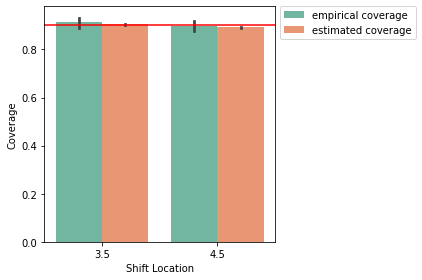

In [40]:
import seaborn as sns
import pandas as pd

melted_df = pd.melt(df, id_vars=['shift_loc'], value_vars=['empirical coverage', 'estimated coverage'])
melted_df = melted_df.rename(columns={"shift_loc": "Shift Location", "value": "Coverage"})

fig = sns.barplot(
    melted_df, 
    x='Shift Location', 
    y='Coverage',
    hue='variable',
    palette=sns.color_palette("Set2")
)
fig.axhline(alpha, color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

fig.get_figure().savefig('synthetic_rkhs_coverage.png')
